# Lab Deep Learning / Multi-Layer Perceptron for binary-classification / in pytorch

**Author: geoffroy.peeters@telecom-paris.fr**

**Version**: 2022/09/19

For any remark or suggestion, please feel free to contact me.

## Objective:

The objective of this lab is to develop a two hidden layers MLP to perform **binary classification**.

We will use a MLP with 2 hidden layer with $n_{h1}=20$ and $n_{h2}=10$ hidden units and ```relu``` activation functions.
You will perform 10.000 iterations (epochs) of SGD to find the parameters.

Note: for this lab, we do not separate the dataset into a train, validation and test part.

### Data normalization

You should normalize the data to zero mean and unit standard deviation

### Model

There are various ways to write NN model in pytorch. 

In this lab, you will write three different implementations:
- **Model A**: manually defining the parameters (W1,b1,W2,b2,W3,b3), writing the forward equations, writting the loss equation, calling the .backward() and manually updating the weights using W1.grad. You will write the loop to perform 1000 epochs.
- **Model B**: using the Sequential class of pytorch
- **Model C**: a custom torch.nn.Module class for this.

For Model B and C, you will use the ready made loss and optimization from the nn and optim packages. You can use the same code to optimize the parameters of Model B and C.

### Loss

Since we are dealing with a binary classification problem, we will use a Binary Cross Entropy loss (use ```torch.nn.BCELoss``` for Model B and C).

### Parameters update/ Optimization

For updating the parameters, we will use as optimizer a simple SGD algorithm (use ```torch.optim.SGD``` for Model B and C) with a learning rate of 0.1.

Don't forget that an optimizer is applied to a set of parameters (```my_model.parameters()``` gives the parameters of the network for Model B and C).
Once the gradients have been computed (after the backpropagation has been performed), you can perform one step of optimization (using ```optimizer.step()``` for Model B and C).

### Backward propagation

Backpropagation is automatically performed in pytorch using the ```autograd``` package. 
First, reset the gradients of all parameters (using ```optimizer.zero_grad()``` for Model B and C), then perform the backpropagation ```loss.backward()```. 

### Your task:

You need to add the missing parts in the code (parts between ```# --- START CODE HERE``` and ```# --- END CODE HERE```)

### Documentation:
- NN: https://pytorch.org/docs/stable/nn.html
- Autograd: https://pytorch.org/docs/stable/autograd.html
- Optim: https://pytorch.org/docs/stable/optim.html


## Load the python packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

student = True

In [2]:
print(torch.__version__)

1.12.1+cu113


## Dataset

We take the usual circle dataset from sklearn.

In [3]:
from sklearn import datasets
X_np, y_np = datasets.make_circles(n_samples=1000, noise=0.2, factor=0.5)

We convert the ```numpy tensors``` to ```torch tensors```. 
The difference being that the latters allows to do automatic gradient differentiation (back-propagation).

In [4]:
X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).float()
y = y.view(len(y), 1)

In [5]:
print(X.size())
print(y.size())
print(X.mean(dim=0))
print(X.std(dim=0))

torch.Size([1000, 2])
torch.Size([1000, 1])
tensor([-0.0134, -0.0009])
tensor([0.5949, 0.6004])


## Normalization

In [6]:
X -= X.mean(dim=0)
X /= X.std(dim=0)
print(X.mean(dim=0))
print(X.std(dim=0))

tensor([ 1.2398e-08, -2.8610e-09])
tensor([1.0000, 1.0000])


## Definition of the hyper-parameters

In [7]:
n_in = X.shape[1]
n_h1 = 20
n_h2 = 10
n_out = 1

nb_epoch = 10000
alpha = 0.1

## Model 1 (writing the network equations)




### Parameter initialization

**Using torch.Tensors**.
You will define the variables and write the equations of the network yourself (as you would do in numpy).
However you will use ```torch.Tensors``` instead of ```numpy.Array```. 

***Why ?*** because torch tensors will allows you to automatically get the gradient. You will use ```loss.backward()``` to launch the backpropagation from ```loss```. Then, for all tensors you've created and for which you declared ```requires_grad=True```, you will get the gradient of ```loss```with respect to this variable in the field ```.grad```. 

Example: ```W1 = torch.Tensor(..., requires_grad=True)``` ... ```loss.backward``` will have the gradient $\frac{d Loss}{d W1}$in ```W1.grad```.

**Rendom initialization**. Don't forget that the weight $W_1, W_2, \cdots$ matrices **should be initialized randomly with small values**; while the bias vectors $b_1, b_2, \cdots$can be initialized to zero.

In [49]:
# --- We first initialize the variables of the network (W1, b1, ...)
if student:
    # --- START CODE HERE (01)
    W1 = torch.randn(n_in, n_h1)
    W1.requires_grad = True
    b1 = torch.zeros(n_h1, requires_grad = True)
    
    W2 = torch.randn(n_h1, n_h2)
    W2.requires_grad = True
    b2 = torch.zeros(n_h2, requires_grad = True)

    W3 = torch.randn(n_h2, n_out)
    W3.requires_grad = True
    b3 = torch.zeros(n_out, requires_grad = True)
    # --- END CODE HERE

### Define the model

We write a function to perform the forward pass (using pytorch operators, not numpy operators) taking X as input and returing hat_y as output.

In [50]:
def model(X):
    if student:
        # --- START CODE HERE (02)
        A0 = X
        Z1 = torch.matmul(A0, W1) + b1
        A1 = F.relu(Z1)
        Z2 = torch.matmul(A1, W2) + b2
        A2 = F.relu(Z2)
        Z3 = torch.matmul(A2, W3) + b3
        A3 = F.sigmoid(Z3)
        hat_y = A3
        # --- END CODE HERE
    return hat_y

### Main training loop

We iterate over epochs (we do not perform split into mini-batch here)
For each iteration, we
- a) perform the forward pass, 
- b) compute the loss/cost, 
- c) compute the backward pass to get the gradients of the cost w.r.t. the parameters W1, b1, ...
- d) perform the update of the parameters W1, b1, ...

***Important: pytorch restriction***
When you update the parameters (W1, b1, ...) but subtracting a small part of the gradient, you should that ``inplace`` (W1 -= ??? and not W1 = W1 - ???). Otherwise pytorch will overide W1 by its value (it will eras its .grad filed).


In [51]:
for num_epoch in range(0, nb_epoch):

    # --- a) Forward pass: X (n_in, m), hat_y (n_out, m)
    hat_y = model(X)

    # -- We clip hat_y in order to avoid log(0) in the loss
    eps = 1e-10
    hat_y = torch.clamp(hat_y, eps, 1-eps)
    
    # --- b) Computing the loss/cost
    if student:
        # --- START CODE HERE (03)
        loss = - (torch.mul(y, torch.log(hat_y)) + torch.mul(1-y, torch.log(1-hat_y)))
        cost = torch.mean(loss)
        # --- END CODE HERE
    
    if num_epoch % 500 == 0:
        print('epoch {}, loss {}'.format(num_epoch, cost))

    # --- c) Backward pass
    cost.backward()
    
    # --- "with torch.no_grad()" temporarily set all the requires_grad flag to false
    with torch.no_grad():
        # --- d) perform the update of the parameters W1, b1, ...
        if student:
            # --- the gradients dLoss/dW1 is stored in W1.grad, dLoss/db1 is stored in b1.grad, ...
            # --- START CODE HERE (04)
            W1 -= alpha*W1.grad
            b1 -= alpha*b1.grad
            W2 -= alpha*W2.grad
            b2 -= alpha*b2.grad
            W3 -= alpha*W3.grad
            b3 -= alpha*b3.grad
            # --- END CODE HERE

    # --- We need to set to zero all gradients (otherwise they are cumulated)
    W1.grad.zero_()
    b1.grad.zero_()
    W2.grad.zero_()
    b2.grad.zero_()
    W3.grad.zero_()
    b3.grad.zero_()

epoch 0, loss 2.3185267448425293
epoch 500, loss 0.2582622170448303
epoch 1000, loss 0.2560993731021881
epoch 1500, loss 0.2546570897102356
epoch 2000, loss 0.2528977394104004
epoch 2500, loss 0.2510729134082794
epoch 3000, loss 0.25011637806892395
epoch 3500, loss 0.24930639564990997
epoch 4000, loss 0.2485312968492508
epoch 4500, loss 0.2477422058582306
epoch 5000, loss 0.24701286852359772
epoch 5500, loss 0.24634063243865967
epoch 6000, loss 0.24580509960651398
epoch 6500, loss 0.24818933010101318
epoch 7000, loss 0.24943123757839203
epoch 7500, loss 0.2494390904903412
epoch 8000, loss 0.2493574470281601
epoch 8500, loss 0.2489832192659378
epoch 9000, loss 0.24868081510066986
epoch 9500, loss 0.2485514134168625


## Model 2 (using nn.sequential)

Here, you will use the package ```torch.nn``` which comes with a predefined set of layers. The syntax is close to the one of ```keras```(```Sequential```), but differs in the fact that layers are splitted into the matrix multiplication followed by a non-linear activations (```keras```merge both using the ```Dense```layers).

The model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```. It is therefore a convenient way to write simple sequential networks.

In [52]:
if student:
    # --- START CODE HERE (05)
    my_model = torch.nn.Sequential(
     torch.nn.Linear(n_in, n_h1),
     torch.nn.ReLU(),
     torch.nn.Linear(n_h1, n_h2),
     torch.nn.ReLU(),
     torch.nn.Linear(n_h2, n_out),
     torch.nn.Sigmoid()
)
    # --- END CODE HERE


### Criterion and Optimization

The code of Model 1 is self-contained, i.e. it already contains all necessary instruction to perform forward, loss, backward and parameter updates.

When using ```nn.sequential``` (model 2) or a class definition of the network (model 3), we still need to define 
- what we will minimize (the loss to be minimized, i.e. Binary-Cross-Entropy). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)
- how we will minimize the loss, i.e. what parameter update algorithms we will use (SGD, momentum). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)

In [54]:
if student:
    # --- START CODE HERE (08)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(my_model.parameters(), lr=alpha)
    # --- END CODE HERE


### Main training loop

Having defined the network, the citerion to be minimized and the optimizer, we then perform a loop over epochs (iterations); at each step we
- compute the forward pass by passing the data to the model: ```haty = model(x)```
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before ```.backward()```)
- performing one step of optimization (using ```.step()```)

epoch 0, loss 0.7023836374282837
epoch 500, loss 0.2702997326850891
epoch 1000, loss 0.2627561390399933
epoch 1500, loss 0.2600468099117279
epoch 2000, loss 0.25898292660713196
epoch 2500, loss 0.25836294889450073
epoch 3000, loss 0.25789740681648254
epoch 3500, loss 0.2577022910118103
epoch 4000, loss 0.2575626075267792
epoch 4500, loss 0.2574547529220581
epoch 5000, loss 0.2573595941066742
epoch 5500, loss 0.25728079676628113
epoch 6000, loss 0.2572082579135895
epoch 6500, loss 0.2571444511413574
epoch 7000, loss 0.25708699226379395
epoch 7500, loss 0.2570349872112274
epoch 8000, loss 0.25698718428611755
epoch 8500, loss 0.25694185495376587
epoch 9000, loss 0.25689688324928284
epoch 9500, loss 0.25684985518455505


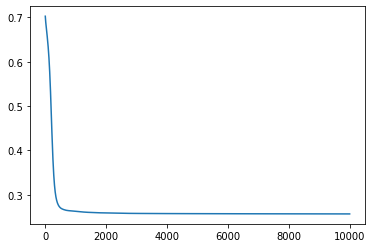

In [55]:
loss_l = []
for num_epoch in range(nb_epoch):
  
    if student:
        # --- START CODE HERE (09)
        hat_y =  my_model(X) # Forward pass: Compute predicted y by passing  x to the model          
        loss = criterion(hat_y,y) # Compute loss 
        # Zero gradients, perform a backward pass, and update the weights. 
        optimizer.zero_grad() # re-init the gradients (otherwise they are cumulated)
        loss.backward() # perform back-propagation
        optimizer.step() # update the weights
        # --- END CODE HERE
        
    loss_l.append(loss.item())

    if num_epoch % 500 == 0:
        print('epoch {}, loss {}'.format(num_epoch, loss.item()))
        
# ----------------
plt.plot(loss_l);

## Model 3 (using a class definition)

Here, you will write the network using the recommended pytroch way; i.e. by defining a class.
This class inherit from the main class ```torch.nn.Module```.
You only need to write the ```__init__``` method and the ```forward``` method.

In object programming, the ```__init__``` method defines the attributes of your class. Since the attributes of your  network are the parameters to be trained (weights and biases), you should declare in the ```__init``` all the layers that involve parameters to be trained (mostly the ```Linear```layers which perform the matrix multiplication).

The ```forward``` method contains the code of the forward pass itself. It can of course call attributes defined in the ```__init___``` method. It is the method used when calling ```model(x)```.

As before, the model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```. 

Classes are convenient way to write more complex network than what you can do with ```nn.sequential```. Note that you can actually include a ```nn.sequential``` in your class.

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, n_in, n_h1, n_h2, n_out):
        super(Net, self).__init__()
        
        if student:
            # --- START CODE HERE (06)
            self.fc1 = torch.nn.Linear(n_in, n_h1) # hidden layer 1
            self.fc2 = torch.nn.Linear(n_h1, n_h2) # hidden layer 2
            self.fc3 = torch.nn.Linear(n_h2, n_out)  # output layer
            # --- END CODE HERE
        
    def forward(self, X):
        
        if student:
            # --- START CODE HERE (07)
            A0 = X
            A1 = F.relu(self.fc1(A0))   # activation function for hidden layer 1
            A2 = F.relu(self.fc1(A1))   # activation function for hidden layer 2
            A3 = F.sigmoid(self.fc1(A2))   # activation function for output layer
            # --- END CODE HERE

        return A3

# --- START CODE HERE
my_model = Net(n_in, n_h1, n_h2, n_out)
# --- END CODE HERE

### Criterion and Optimization (same as for model 2 -> copy and paste your code)

In [57]:
if student:
    # --- START CODE HERE (08)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(my_model.parameters(), lr=alpha)
    # --- END CODE HERE


### Main training loop (same as for model 2 -> copy and paste your code)


epoch 0, loss 0.25680112838745117
epoch 500, loss 0.25675705075263977
epoch 1000, loss 0.2567148506641388
epoch 1500, loss 0.25667378306388855
epoch 2000, loss 0.256633460521698
epoch 2500, loss 0.2565951645374298
epoch 3000, loss 0.2565571069717407
epoch 3500, loss 0.2565188407897949
epoch 4000, loss 0.25648343563079834
epoch 4500, loss 0.25644537806510925
epoch 5000, loss 0.2563847005367279
epoch 5500, loss 0.25619304180145264
epoch 6000, loss 0.25599294900894165
epoch 6500, loss 0.2557765543460846
epoch 7000, loss 0.25558164715766907
epoch 7500, loss 0.2554547190666199
epoch 8000, loss 0.2553638219833374
epoch 8500, loss 0.25527986884117126
epoch 9000, loss 0.255215048789978
epoch 9500, loss 0.2551526725292206


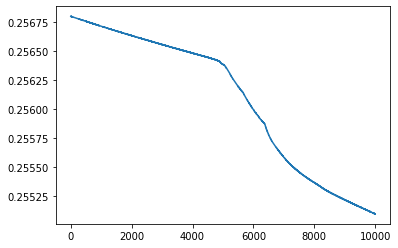

In [56]:
loss_l = []
for num_epoch in range(nb_epoch):
  
    if student:
        # --- START CODE HERE (09)
        hat_y =  my_model(X) # Forward pass: Compute predicted y by passing  x to the model          
        loss = criterion(hat_y,y) # Compute loss 
        # Zero gradients, perform a backward pass, and update the weights. 
        optimizer.zero_grad() # re-init the gradients (otherwise they are cumulated)
        loss.backward() # perform back-propagation
        optimizer.step() # update the weights
        # --- END CODE HERE
        
    loss_l.append(loss.item())

    if num_epoch % 500 == 0:
        print('epoch {}, loss {}'.format(num_epoch, loss.item()))
        
# ----------------
plt.plot(loss_l); 

# Evaluation

To evaluate the work, you should rate the code for 
- 1) Model 1: Initialization of W1, b1, ... (01)
- 2) Model 1: Forward-pass (02)
- 3) Model 1: Loss and Cost computation  (03)
- 4) Model 1: Manual update of the parameters (04)
- 5) Model 2: using nn.sequential (05)
- 6) Model 3: using class definition: __init__ method (06)
- 7) Model 3: using class definition: forward method (07)
- 8) Model 2 and 3: Loss (criterion) and parameter update algorithms (optimizer) (08)
- 9) Model 2 and 3: code inside the loop (09)